# Deel 1 : Productieproces
## Imports, Directories

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import scipy.stats
import os
import json
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
dirnb = os.getcwd()
print(dirnb)

dirscripts  = os.path.join(os.path.dirname(os.getcwd()), "Scripts")
print(dirscripts)

dirdataprod = os.path.join(os.path.dirname(os.getcwd()), "Data\Input\Data_productie")
print(dirdataprod)

dirbru      = os.path.join(os.path.dirname(os.getcwd()), "Data\Input\Data_productie\Daily_production\BRU")
print(dirbru)

dirsto      = os.path.join(os.path.dirname(os.getcwd()), "Data\Input\Data_productie\Daily_production\STO")
print(dirsto)

C:\Users\BE76820\OneDrive - AGC\Documents\Syntra 2023-2024\Adinda DS Werkplaats\10ter GIT Statistiek Opdracht\Notebooks
C:\Users\BE76820\OneDrive - AGC\Documents\Syntra 2023-2024\Adinda DS Werkplaats\10ter GIT Statistiek Opdracht\Scripts
C:\Users\BE76820\OneDrive - AGC\Documents\Syntra 2023-2024\Adinda DS Werkplaats\10ter GIT Statistiek Opdracht\Data\Input\Data_productie
C:\Users\BE76820\OneDrive - AGC\Documents\Syntra 2023-2024\Adinda DS Werkplaats\10ter GIT Statistiek Opdracht\Data\Input\Data_productie\Daily_production\BRU
C:\Users\BE76820\OneDrive - AGC\Documents\Syntra 2023-2024\Adinda DS Werkplaats\10ter GIT Statistiek Opdracht\Data\Input\Data_productie\Daily_production\STO


## Run Scripts

In [3]:
# Temporary set "dirscripts" as "cwd" and Execute Scripts
os.chdir(dirscripts)
os.getcwd()

'C:\\Users\\BE76820\\OneDrive - AGC\\Documents\\Syntra 2023-2024\\Adinda DS Werkplaats\\10ter GIT Statistiek Opdracht\\Scripts'

In [4]:
os.listdir()

['.gitkeep', 'df_from_json_files.py']

In [5]:
##### %run scripts


## Read Production Data BRU & STO

In [6]:
# Create dictionary from input file "master_data.json"
# MSR = Maximum Sustainable Rate

with open(os.path.join(dirdataprod, 'master_data.json')) as file:
    dicmsr = json.loads(file.read())
    
print(dicmsr, dicmsr["BRU msr"], dicmsr["STO msr"])


{'BRU msr': 1244, 'STO msr': 274} 1244 274


In [7]:
# Functie die 
# 1) de folder "directory" tijdelijk als "cwd" zet, en
# 2) daarna een DataFrame "df" creëert vanuit .json files die zich in die folder "directory" bevinden 

def df_from_json_files (directory) :
    
    os.chdir(directory)
    
    data_list = []

    for file in os.listdir(directory) :
        with open(file) as file:
            data = json.loads(file.read())
        data_list.append(data)

    df = pd.DataFrame(data_list)
    return df  

In [8]:
# Create dataframe "dfbru" dat de productiegegevens van BRU(ssel) bevat
dfbru = df_from_json_files (dirbru)
dfbru["City"] = "BRU"
dfbru.head()

,DoW,hour,minute,date,maintenance,prod_loss,prod_loss_perc,production,City
0,Monday,1,0,01-01-2018 00:00:00.0000,No,61,5,1183,BRU
1,Tuesday,1,0,01-02-2018 00:00:00.0000,No,106,9,1138,BRU
2,Wednesday,1,0,01-03-2018 00:00:00.0000,No,129,10,1115,BRU
3,Thursday,1,0,01-04-2018 00:00:00.0000,No,278,22,966,BRU
4,Friday,1,0,01-05-2018 00:00:00.0000,No,218,17,1026,BRU


In [9]:
# Create dataframe "dfsto" dat de productiegegevens van STO(ckholm) bevat
dfsto = df_from_json_files (dirsto)
dfsto["City"] = "STO"
dfsto.head()

,DoW,hour,minute,date,maintenance,prod_loss,prod_loss_perc,production,City
0,Monday,1,0,01-01-2018 00:00:00.0000,No,9,3,265,STO
1,Tuesday,1,0,01-02-2018 00:00:00.0000,No,9,3,265,STO
2,Wednesday,1,0,01-03-2018 00:00:00.0000,No,18,6,256,STO
3,Thursday,1,0,01-04-2018 00:00:00.0000,No,22,8,252,STO
4,Friday,1,0,01-05-2018 00:00:00.0000,No,31,11,243,STO


In [10]:
# Zet de directory "dirnb" opnieuw als "cwd"
os.chdir(dirnb)
os.getcwd()

'C:\\Users\\BE76820\\OneDrive - AGC\\Documents\\Syntra 2023-2024\\Adinda DS Werkplaats\\10ter GIT Statistiek Opdracht\\Notebooks'

## Clean Production Data BRU & STO

In [11]:
def df_clean(df) :
    df_cleaned = df.copy()
    df_cleaned.drop(["hour", "minute"], axis = 1, inplace = True)
    df_cleaned.replace('#MV', np.NaN, inplace = True)
    df_cleaned.fillna(0, inplace = True)
    df_cleaned["prod_loss"] = df_cleaned["prod_loss"].astype(int)
    df_cleaned["prod_loss_perc"] = df_cleaned["prod_loss_perc"].astype(int)
    df_cleaned["production"] = df_cleaned["production"].astype(int)
    df_cleaned["date"] = pd.to_datetime(df_cleaned["date"]).dt.date
    df_cleaned["date"] = df_cleaned["date"].astype('datetime64[ns]')
    
    return df_cleaned


In [12]:
dfbru1 = df_clean(dfbru)
dfbru1.dtypes


DoW                       object
date              datetime64[ns]
maintenance               object
prod_loss                  int32
prod_loss_perc             int32
production                 int32
City                      object
dtype: object

In [13]:
dfbru1.head()

,DoW,date,maintenance,prod_loss,prod_loss_perc,production,City
0,Monday,2018-01-01,No,61,5,1183,BRU
1,Tuesday,2018-01-02,No,106,9,1138,BRU
2,Wednesday,2018-01-03,No,129,10,1115,BRU
3,Thursday,2018-01-04,No,278,22,966,BRU
4,Friday,2018-01-05,No,218,17,1026,BRU


In [14]:
dfsto1 = df_clean(dfsto)
dfsto1.dtypes


DoW                       object
date              datetime64[ns]
maintenance               object
prod_loss                  int32
prod_loss_perc             int32
production                 int32
City                      object
dtype: object

In [15]:
dfsto1.head()

,DoW,date,maintenance,prod_loss,prod_loss_perc,production,City
0,Monday,2018-01-01,No,9,3,265,STO
1,Tuesday,2018-01-02,No,9,3,265,STO
2,Wednesday,2018-01-03,No,18,6,256,STO
3,Thursday,2018-01-04,No,22,8,252,STO
4,Friday,2018-01-05,No,31,11,243,STO


In [16]:
# dfbru1.to_excel("bru1.xlsx", index = False)
# dfsto1.to_excel("sto1.xlsx", index = False)

## Analyse Production Data BRU

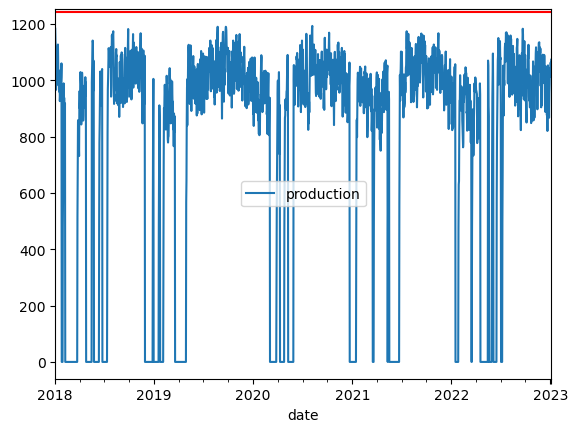

In [17]:
# Productie over voorbije jaren visualiseren (ter info)
dfbru1.plot("date", "production")
plt.axhline(dicmsr["BRU msr"], color = 'r')

In [18]:
# Maintenance dagen verwijderen
dfp = dfbru1.loc[dfbru1["maintenance"] == "No",:].copy()
dfp.reset_index(inplace = True)
#display(dfp)

array([[<Axes: title={'center': 'production'}>]], dtype=object)

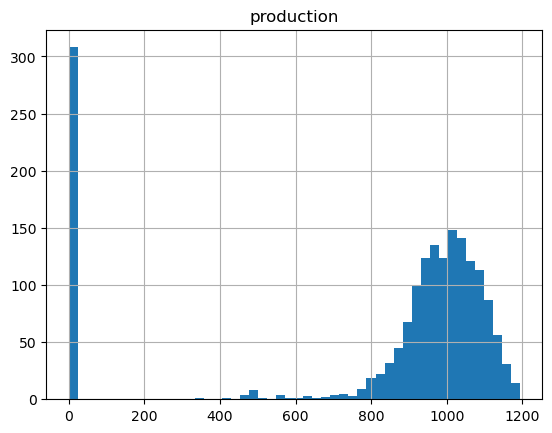

In [19]:
dfp.hist("production", bins = 50)

### Verdeling bepalen voor productie van 1 dag

In [20]:
# Parameters (mean & std) bepalen van de Normale verdeling die de "niet-nul" productiedagen fit
# de "niet-nul" productiedagen : dfp.loc[dfp["production"] != 0,:]

dfp_not_0_model = scipy.stats.norm.fit(dfp.loc[dfp["production"] != 0,:]["production"])

print(dfp_not_0_model, dfp_not_0_model[0], dfp_not_0_model[1])


(989.218487394958, 108.90790262811456) 989.218487394958 108.90790262811456


In [21]:
# Percentage van "nul" productiedagen bepalen

perc_0 = np.mean(dfp["production"] == 0)   # dfp["production"] == 0 is een Boolean Series
print(perc_0)


0.1774193548387097


In [22]:
# Model voor productie van 1 dag bepalen :
# p% kans = 0
# (1-p)% kans trekking uit de Normale verdeling die de "niet-nul" productiedagen fit

def model_prod1 (p, mu, sigma, size = None):
    # Remark: size not implemented yet!
    
    a = np.random.rand()
    
    if a < p:
        return 0
    else:
        return np.random.normal(loc = mu, scale = sigma)
    
# b = model_prod1(perc_0, dfp_not_0_model[0], dfp_not_0_model[1])     
# print(b)


(array([336.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          2.,   1.,   2.,   2.,   5.,  12.,  16.,  38.,  68.,  95., 106.,
        129., 156., 141., 181., 153., 145., 112.,  83.,  83.,  57.,  35.,
         19.,   9.,   5.,   6.,   2.,   1.]),
 array([   0.        ,   27.13997334,   54.27994668,   81.41992002,
         108.55989336,  135.6998667 ,  162.83984003,  189.97981337,
         217.11978671,  244.25976005,  271.39973339,  298.53970673,
         325.67968007,  352.81965341,  379.95962675,  407.09960009,
         434.23957343,  461.37954676,  488.5195201 ,  515.65949344,
         542.79946678,  569.93944012,  597.07941346,  624.2193868 ,
         651.35936014,  678.49933348,  705.63930682,  732.77928015,
         759.91925349,  787.05922683,  814.19920017,  841.33917351,
         868.47914685,  895.61912019,  922.75909353,  949.89906687,
         977.03904021, 1004.17901355, 1031.318

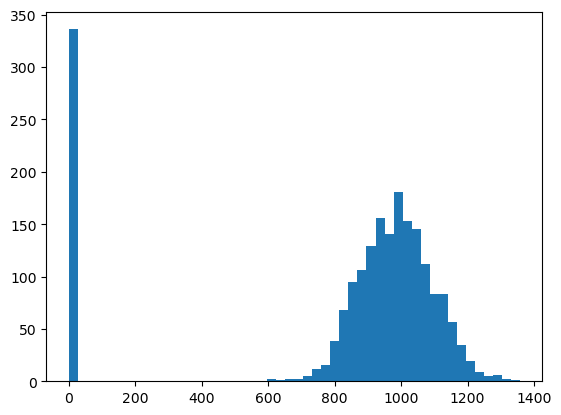

In [23]:
# Maak een simulatie van het Model voor de productie van 1 dag
SS = 2000
simulation_prod1 = [model_prod1(perc_0, dfp_not_0_model[0], dfp_not_0_model[1]) for _ in range(SS)]
#print(simulation_prod1)

plt.hist(simulation_prod1, bins=50)


(array([6.19013136e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 3.68460200e-05, 1.84230100e-05,
        3.68460200e-05, 3.68460200e-05, 9.21150500e-05, 2.21076120e-04,
        2.94768160e-04, 7.00074380e-04, 1.25276468e-03, 1.75018595e-03,
        1.95283906e-03, 2.37656829e-03, 2.87398956e-03, 2.59764441e-03,
        3.33456481e-03, 2.81872053e-03, 2.67133645e-03, 2.06337712e-03,
        1.52910983e-03, 1.52910983e-03, 1.05011157e-03, 6.44805350e-04,
        3.50037190e-04, 1.65807090e-04, 9.21150500e-05, 1.10538060e-04,
        3.68460200e-05, 1.84230100e-05]),
 array([   0.        ,   27.13997334,   54.27994668,   81.41992002,
         108.55989336,  13

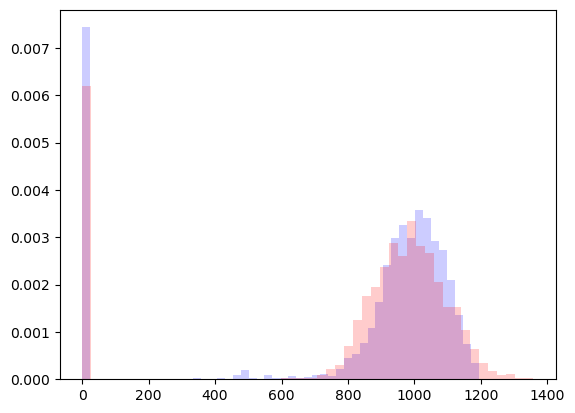

In [24]:
# Beide Density Histogrammen in 1 figuur

plt.hist(dfp["production"], density = True, color = 'b', bins = 50, alpha = 0.2)
plt.hist(simulation_prod1, density = True, color = 'r', bins = 50, alpha = 0.2)


### Simulatie van totale productie over periode van n dagen

In [25]:
n = 5
SS = 2000
simulation_prodn = [sum([model_prod1(perc_0, dfp_not_0_model[0], dfp_not_0_model[1]) for _ in range(n)]) for k in range(SS)]

(array([ 1.,  1.,  2.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  1.,  7.,  7., 10.,  7.,  7.,  9.,  4.,
         8.,  3.,  6.,  3.,  1.,  0.,  1.,  1.,  0.,  2.,  6., 11., 12.,
        12., 21., 20., 27., 33., 39., 35., 30., 26., 27., 24., 14., 15.,
         3.,  3.,  6.,  8., 15., 25., 28., 43., 61., 44., 56., 62., 68.,
        73., 78., 63., 41., 38., 32., 33., 14., 20., 17., 14., 13., 24.,
        24., 30., 35., 48., 47., 49., 60., 67., 48., 60., 39., 40., 44.,
        26., 20., 10., 12.,  8.,  4.,  7.,  2.,  1.]),
 array([ 835.37778616,  883.44838444,  931.51898271,  979.58958098,
        1027.66017926, 1075.73077753, 1123.8013758 , 1171.87197408,
        1219.94257235, 1268.01317063, 1316.0837689 , 1364.15436717,
        1412.22496545, 1460.29556372, 1508.366162  , 1556.43676027,
        1604.50735854, 1652.57795682, 1700.64855509, 1748.71915336,
        1796.78975164, 1844.86034991, 1892.93094819, 1941.00154646,
        1989.07214473, 203

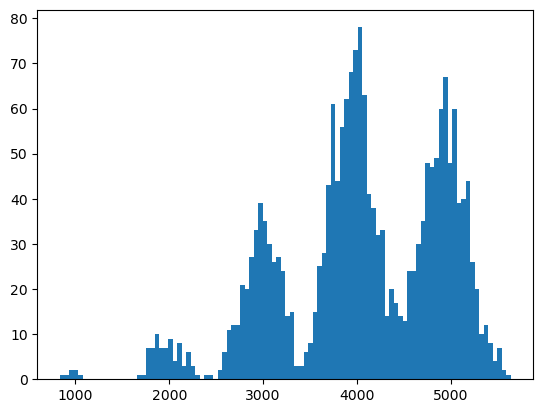

In [26]:
plt.hist(simulation_prodn, bins = 100)